In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pow
from random import random
import pandas
import pandas_datareader as pdr
from datetime import datetime
import operator

import findspark
#use python -m pip install xxxx for missing package

os.environ["SPARK_HOME"] = '/opt/apache-spark/spark-3.0.1-bin-hadoop2.7'
findspark.init()

import pyspark
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


# Read Data from yahoo finance

In [2]:
start_date = datetime(1990, 1, 1)
end_date = datetime(2020, 8, 31)

#Update Here! get more feature if needed
spx = pdr.get_data_yahoo(symbols='^SP500TR', start=start_date, end=end_date)["Adj Close"]
vix = pdr.get_data_yahoo(symbols='^vix', start=start_date, end=end_date)["Adj Close"]
bnp = pandas.concat([spx, vix], axis=1)
#Update Here! update column name base on features
bnp.columns = ('spx','vix')
bnp = bnp.sort_values(by="Date",ascending=True)
print(bnp.head(10))
bnp.to_csv('Result.csv')

                   spx        vix
Date                             
1990-01-02  386.160004  17.240000
1990-01-03  385.170013  18.190001
1990-01-04  382.019989  19.219999
1990-01-05  378.299988  20.110001
1990-01-08  380.040009  20.260000
1990-01-09  375.559998  22.200001
1990-01-10  373.089996  22.440001
1990-01-11  374.399994  20.049999
1990-01-12  365.220001  24.639999
1990-01-15  362.079987  26.340000


# Prepare Spark

In [3]:
#run on local with 2 core
spark = SparkSession.builder.appName("examples").master('local[2]').getOrCreate()

# Prepare data for training and validation

In [4]:
data = pandas.read_csv('Result.csv')
data['Date'] = pandas.to_datetime(data['Date']) 
#length used for regression,regression_length=n means data t-1 ~ t-n will be used for regression 
#Update Here! change regression_length
regression_length=5

#Update Here! update column name base on features
spx = data['spx']
vix = data['vix']
for i in range(1,regression_length+1):
    data[f'spx t-{i}'] = spx.shift(i)
    data[f'vix t-{i}'] = vix.shift(i)    
#remove NaN data
data.dropna(inplace=True)
print(data.head(10))

         Date         spx        vix     spx t-1    vix t-1     spx t-2  \
5  1990-01-09  375.559998  22.200001  380.040009  20.260000  378.299988   
6  1990-01-10  373.089996  22.440001  375.559998  22.200001  380.040009   
7  1990-01-11  374.399994  20.049999  373.089996  22.440001  375.559998   
8  1990-01-12  365.220001  24.639999  374.399994  20.049999  373.089996   
9  1990-01-15  362.079987  26.340000  365.220001  24.639999  374.399994   
10 1990-01-16  366.119995  24.180000  362.079987  26.340000  365.220001   
11 1990-01-17  362.540009  24.160000  366.119995  24.180000  362.079987   
12 1990-01-18  363.380005  24.340000  362.540009  24.160000  366.119995   
13 1990-01-19  364.429993  22.500000  363.380005  24.340000  362.540009   
14 1990-01-22  355.040009  26.700001  364.429993  22.500000  363.380005   

      vix t-2     spx t-3    vix t-3     spx t-4    vix t-4     spx t-5  \
5   20.110001  382.019989  19.219999  385.170013  18.190001  386.160004   
6   20.260000  378.29998

# Convert to Spark Dataframe

In [5]:
#convert panda dataframe to spark dataframe
df = spark.createDataFrame(data)
#use t-n data as features (x)
feature_cols = list(filter(lambda s:'t-' in s,df.columns))
vecAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = vecAssembler.transform(df)
#use spx as label (y)
df = df.withColumnRenamed("spx","label")


#Update Here! update validation_date
#date afterward will be used for validation
validation_date = datetime(2015, 1, 1)
#Update Here! update filter rule if needed for start and end time
train_df = df.filter(df["Date"] < validation_date)
validation_df =  df.filter(df["Date"] >= validation_date)

# Train Model

In [6]:
lr =  LinearRegression()
model = lr.fit(train_df)

# Validate Model

In [7]:
x = list(map(lambda a:a[0],validation_df.select("features").collect()))
y_actual =  list(map(lambda a:a[0],validation_df.select("label").collect()))
y_predict = list(map(lambda x:model.predict(x),x))
delta =  list(map(operator.sub, y_actual, y_predict))

In [8]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_actual,y_predict)
print(f'RMS is {rms}')

RMS is 3689.602062977286


In [9]:
# Plot result of last 10 day

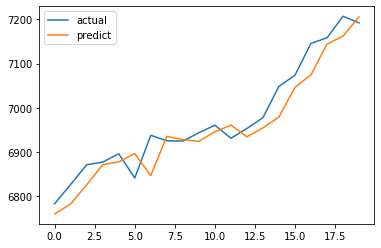

In [10]:
plt.plot(y_actual[-20:],label='actual')
plt.plot(y_predict[-20:],label='predict')
plt.legend()
plt.show()